In [219]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from utils import get_bounding_box_dims,IOU,affine_Inv,show_img


In [220]:
test_class = "BlurCar2"   
inp_path = test_class+"\img"
gt_path = test_class+"\groundtruth_rect.txt"
ssd = False
show = True
multiscale = False
adaptive = True
thresh=0.001
image_list = os.listdir(inp_path)
org_image = cv2.imread(os.path.join(inp_path,image_list[0]))
gt_file = open(gt_path,'r')
gt_file_content = gt_file.readlines()
gt_box_dims = get_bounding_box_dims(gt_file_content, 1)
template = org_image[gt_box_dims[1]:gt_box_dims[3],gt_box_dims[0]:gt_box_dims[2]]

template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
t_shape=template.shape
iou_sum = 0.0

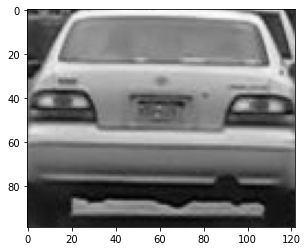

In [221]:
plt.imshow(template,cmap='gray')

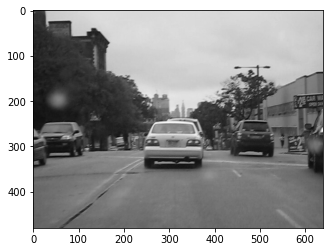

In [222]:
frame = cv2.imread(os.path.join(inp_path,image_list[6]))
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
plt.imshow(frame,cmap='gray')

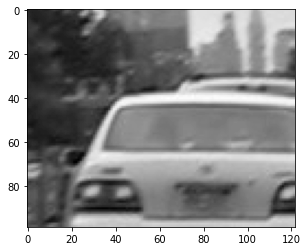

In [202]:
input_frame = frame[gt_box_dims[1]:gt_box_dims[3],gt_box_dims[0]:gt_box_dims[2]]
plt.imshow(input_frame,cmap='gray')

In [203]:
for i in range(6,7):

    frame = cv2.imread(os.path.join(inp_path,image_list[i]))
    frame = cv2.bilateralFilter(frame,15,75,75)
    rows, cols, ch = frame.shape
    size = (rows,cols)
   
    # Below VideoWriter object will create
    # a frame of above defined The output 
    # is stored in 'filename.avi' file.
    result = cv2.VideoWriter('filename.avi', 
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         10, size)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    #show_img(frame)
    # gt_box_dims = get_bounding_box_dims(gt_file_content, i)
    box_pred = [0,0,0,0]

    """Initialization for affine"""
    # p = np.zeros([1,6], dtype = np.float64)
    W = np.array([[1,0,0],
                [0, 1,0]],dtype = np.float64)
    thresh=.07
    error=1
    itr=0
    errors=[]
    x=[]
    ssd=0
    norms=[]
    norm_so_far=1e6
    while(error > thresh):
        """Warping """
        frame = cv2.warpAffine(frame, W, (frame.shape[1], frame.shape[0]))
        name = inp_path.split("\\")[0]
        if not os.path.isdir(name+"/LK_itr/"):
            os.mkdir(name+"/LK_itr/")
            cv2.imwrite(name+"/LK_itr/"+str(itr)+".png",cv2.resize(input_frame,(frame.shape[1], frame.shape[0])))
        else:
            cv2.imwrite(name+"/LK_itr/"+str(itr)+".png",cv2.resize(input_frame,(frame.shape[1], frame.shape[0])))
        input_frame = frame[gt_box_dims[1]:gt_box_dims[3],gt_box_dims[0]:gt_box_dims[2]]
        """Compute Error"""
        diff = template-input_frame
        
        diff2=cv2.subtract(input_frame,template)
        norm_1=np.linalg.norm(diff2)
        norms.append(norm_1)
        norm_so_far=min(norm_1,norm_so_far)
        if(norm_1 > norm_so_far):
            break
        """Compute Warped Gradients"""
        gradX = cv2.Sobel(frame ,cv2.CV_64F, 1, 0, ksize=5)
        gradY = cv2.Sobel(frame, cv2.CV_64F, 0, 1, ksize=5)
        gradX = gradX[gt_box_dims[1]:gt_box_dims[3],gt_box_dims[0]:gt_box_dims[2]]
        gradY = gradY[gt_box_dims[1]:gt_box_dims[3],gt_box_dims[0]:gt_box_dims[2]]
        ht, wt = template.shape
        Xc = np.tile(np.linspace(0, wt-1, wt), (ht, 1))
        Yc = np.tile(np.linspace(0, ht-1, ht), (wt, 1)).T
        """Compute Steepest Descent"""
        steepestDescentImages=[]
        steepestDescentImages.append(np.multiply(Xc,gradX))
        steepestDescentImages.append(np.multiply(Xc,gradY))
        steepestDescentImages.append(np.multiply(Yc,gradX))
        steepestDescentImages.append(np.multiply(Yc,gradY))
        steepestDescentImages.append(gradX)
        steepestDescentImages.append(gradY)
        """Compute Inverse Hessian"""
        l_2=[]
        for k in range(6):
            for j in range(6):
                a=steepestDescentImages[k]
                b=steepestDescentImages[j]
                c=np.multiply(a,b)
                l_2.append(np.sum(c))
        l_2=np.array(l_2)
        hess=l_2.reshape((6,6))
        l_3=[]
        for k in range(6):
            a=steepestDescentImages[k]
            c=np.multiply(a,diff)
            l_3.append(np.sum(c))
        l_3=np.array(l_3)
        if np.linalg.matrix_rank(hess) != 6:
            print("hessian is singular")
            error=0
            continue
        """Compute delp by Multplying steepest Descent,Inverse Hessian,"""
        delp = np.matmul(np.linalg.inv(hess), l_3)
        """Update p"""
        error = np.linalg.norm(delp)
        #print(error)
        "if(error>0.5):"
        "    break"
        W= W + np.array([[delp[0],delp[2],delp[4]], [delp[1],delp[3],delp[5]]]) 
        errors.append(error)
        itr+=1
        x.append(itr)
   
    #plt.plot(x,norms)
    result.release()
    cornerPoints=np.array([[gt_box_dims[0],gt_box_dims[1]],[gt_box_dims[2],gt_box_dims[1]],[gt_box_dims[1],gt_box_dims[3]],[gt_box_dims[2],gt_box_dims[3]]])
    plotPts=[]
    for x,y in cornerPoints:
        pos=np.matmul(affine_Inv(W),[x,y,1])
        plotPts.append(pos)
    plotPts=np.array(plotPts)   
    plotPts = np.round(plotPts.astype(int))


    box_pred =[plotPts[0][0],plotPts[0][1],plotPts[-1][0],plotPts[-1][1]] 




    source = cv2.imread(os.path.join(inp_path,image_list[i]))
    box_gt= get_bounding_box_dims(gt_file_content, i+1)
    iou_sum += IOU(box_gt,box_pred)

    # diff = template - input_frame
    # ssd=np.sum(np.multiply(diff,diff))
    # if(ssd < 0.1):
    t_shape=(box_pred[2]-box_pred[0],box_pred[3]-box_pred[1])
    template = frame[box_pred[1]:box_pred[3],box_pred[0]:box_pred[2]]
    #plt.imshow(template,cmap='gray')
    template = cv2.resize(template, t_shape)
    gt_box_dims=box_pred
    if show:
        name = inp_path.split("\\")[0]
        pred_img = cv2.rectangle(source,(box_gt[0],box_gt[1]),(box_gt[2],box_gt[3]),(0,255,0),2)
        pred_img = cv2.rectangle(pred_img,(box_pred[0],box_pred[1]),(box_pred[2],box_pred[3]),(255,0,0),2)
        pred_img=cv2.rectangle(pred_img,(gt_box_dims[0],gt_box_dims[1]),(gt_box_dims[2],gt_box_dims[3]),(0,0,255),2)
        if not os.path.isdir(name+"/processed/"):
            os.mkdir(name+"/processed/")
            cv2.imwrite(name+"/processed/"+str(i)+".png",pred_img)
        else: 
            cv2.imwrite(name+"/processed/"+str(i)+".png",pred_img)
        

error: OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-sn_xpupm\opencv\modules\imgproc\src\resize.cpp:4054: error: (-215:Assertion failed) inv_scale_x > 0 in function 'cv::resize'


In [ ]:
print(itr)

In [216]:
def affine_Inv(prevWarp):
    R = prevWarp[:,0:2]
    rinv = np.linalg.inv(R)
    trans = np.matmul(rinv,prevWarp[:,2])
    pinv = np.array( [ [rinv[0,0], rinv[0,1] , -trans[0]],  [rinv[1,0], rinv[1,1] , -trans[1]]  ])
    return pinv

In [217]:
def affine_inv_2(W):
    row_to_be_added = np.array([0, 0, 1],dtype=np.float64)
    W=np.vstack((W,row_to_be_added))
    W_inv=np.linalg.inv(W)
    return W_inv[0:2]

In [218]:
W = np.array([[1,0.5,6],
                    [0.3, 0.1,7]],dtype = np.float64)
print(affine_Inv(W),affine_inv_2(W))

[[ -2.  10. -58.]
 [  6. -20. 104.]] [[ -2.  10. -58.]
 [  6. -20. 104.]]
